# Beauty Classifier


In [3]:
# !pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [1]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Initialization
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

Records loaded. 1576 out of 3216 photos have been labeled stunning.

Displaying images scored 0:
['2018/11/28/2018_1128_133000/thumbnail.jpg']


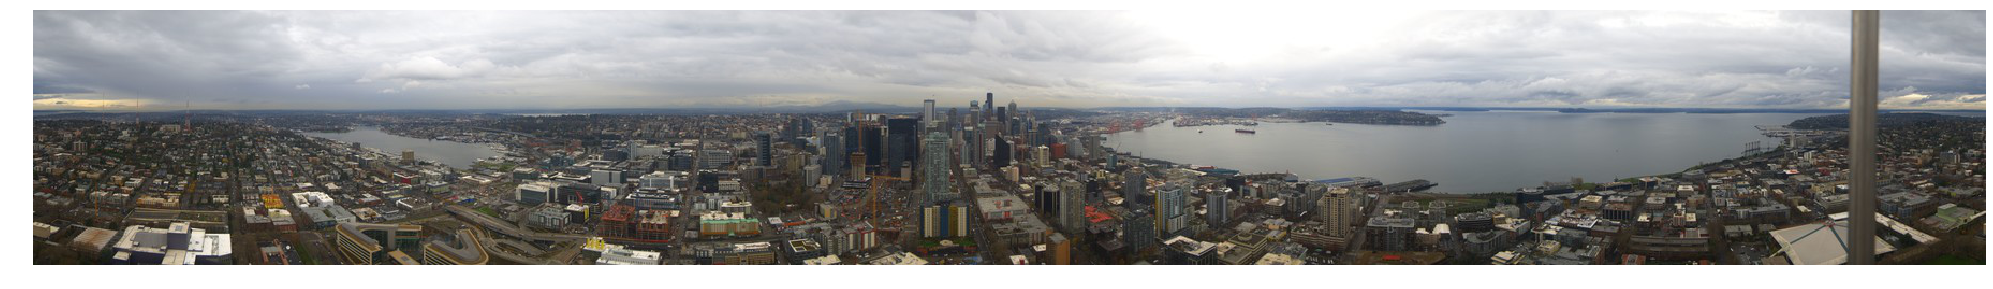

In [3]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    scores = sum(v['score'] for k, v in record.items())
    print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 0)

In [ ]:
from IPython.display import Image

fn = '../data/interim/_1130_4528215.png'
display(Image(filename=fn) )

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

pil_im = Image.open(fn) #Take jpg + png
## Uncomment to open from URL
#import requests
#r = requests.get('https://www.vegvesen.no/public/webkamera/kamera?id=131206')
#pil_im = Image.open(BytesIO(r.content))
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

OSError: cannot identify image file '../data/interim/_1130_4528215.png'

In [4]:
img.shape

(237, 1820, 3)

# Prep Data

In [4]:
import boto3
import os
from PIL import Image
from sklearn.model_selection import train_test_split


s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def clean_data(data):
    local_files = os.listdir("../data/imgs/")
    bad_files = []
    for file in data['filename']:
        im = Image.open('../data/imgs/' + file)
        shape = np.array(im).shape
        if shape != (237, 1820, 3):
            bad_files.append(file)
            print(f'{file} is wrong shape! Deleting!')
    for file in bad_files:
        data = data[data['filename'] != file]
    save_to(data, '../data/interim/clean_data.pkl')
    return data
    
    
def download_from_s3(prefix, local_path, bucket=bucket_name, client=s3_client, resource=s3_resource):
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket': bucket_name,
        'Prefix': prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = s3_client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        resource.meta.client.download_file(bucket, k, local_path)
    return


def get_files(data, path):
    local_files = set(os.listdir("../data/imgs/"))
    target_files = set(data['filename'])
    missing = target_files.difference(local_files)
    needed = data[data['filename'].isin(missing)]
    
    new_files = 0
    if len(needed) > 0:
        print(f'Getting {len(missing)} files from S3...')
        needed.apply(lambda x: download_from_s3(x['filepath'], path + x['filename']), axis=1)
        print('Success!\n')
        new_files = 1
        
    return new_files


def process_df(df):
    parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
    date_strings = df['index'].apply(parse)
    filenames = date_strings + 'thumb.jpg'
    df['filename'] = filenames

    df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
    df = df.rename(columns={'index': 'filepath'})
    save_to(df, '../data/interim/data.pkl')
    
    df['target'] = df.apply(lambda x: ['fine', 'beautiful'][x['score'] > 2], axis=1)
#     df = pd.concat((df, pd.get_dummies(df['target'])), axis=1)
    return df


def get_df_from_record():
    record = get_record()
    df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
    save_to(df, '../data/raw/df.pkl')
    return df


def run():
    path = '../data/imgs/'
    if 'imgs' not in os.listdir('../data/'):
        os.mkdir('../data/imgs')
    
    df = get_df_from_record()
    data = process_df(df)
    new_files = get_files(data, path)
#     if new_files:
    data = clean_data(data)
        
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    save_to(train, '../data/processed/train.pkl')
    save_to(val, '../data/processed/val.pkl')
    save_to(test, '../data/processed/test.pkl')
    
    proportion = lambda x: sum(x['score'].value_counts()[1:]) / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return data

In [26]:
data = run()

Saved file to ../data/raw/df.pkl
Saved file to ../data/interim/data.pkl
201806280510thumb.jpg is wrong shape! Deleting!
201806282130thumb.jpg is wrong shape! Deleting!
201810070650thumb.jpg is wrong shape! Deleting!
Saved file to ../data/interim/clean_data.pkl
Saved file to ../data/processed/train.pkl
Saved file to ../data/processed/val.pkl
Saved file to ../data/processed/test.pkl

Train set has 2056 images with 40.86% positive class.
Val set has 514 images with 42.61% positive class.
Test set has 643 images with 47.12% positive class.



In [22]:
sum(data['score'].value_counts()[1:])

1362

In [27]:
len(data)

3213

In [7]:
from PIL import Image

local_files = os.listdir("../data/imgs/")
for file in local_files:
    im = Image.open('../data/imgs/' + file)
    shape = np.array(im).shape
    if shape != (237, 1820, 3):
        print(file, shape)

201712041110thumb.jpg (13958, 1820, 3)
201810010650thumb.jpg (13958, 1820, 3)
201602270840thumb.jpg (13958, 1820, 3)
201606130510thumb.jpg (13958, 1820, 3)
201807030910thumb.jpg (13958, 1820, 3)
201603020722thumb.jpg (13958, 1820, 3)
201901271120thumb.jpg (13958, 1820, 3)
201604092020thumb.jpg (13958, 1820, 3)
201811290720thumb.jpg (13958, 1820, 3)
201806280510thumb.jpg (13958, 1820, 3)
201608110540thumb.jpg (13958, 1820, 3)
201810111840thumb.jpg (13958, 1820, 3)
201802031020thumb.jpg (13958, 1820, 3)
201510281020thumb.jpg (13958, 1820, 3)
201703021750thumb.jpg (13958, 1820, 3)
201809241120thumb.jpg (13958, 1820, 3)
201812170830thumb.jpg (13958, 1820, 3)
201810070650thumb.jpg (13958, 1820, 3)
201806240620thumb.jpg (13958, 1820, 3)
201811080710thumb.jpg (13958, 1820, 3)
201811170750thumb.jpg (13958, 1820, 3)
201809052040thumb.jpg (13958, 1820, 3)
201712171130thumb.jpg (13958, 1820, 3)
201809161950thumb.jpg (13958, 1820, 3)
201806282130thumb.jpg (13958, 1820, 3)


## Extract features from convolutional base

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as beautiful or not. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [5]:
# Imports
import os, shutil, sys
from time import time
import matplotlib.pyplot as plt

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception


Using TensorFlow backend.


In [6]:
K.clear_session()

In [7]:
def visualize_training(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return

    
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    # Flip 1s and 0s
    y_true = 1 - y_true
    y_pred = 1 - y_pred
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f2(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    beta = 2
    f2 = (1 + beta**2 * prec * rec) / (beta**2 * prec + rec + K.epsilon())
    return f2


def get_datagen(data, set_name, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_dataframe(
        dataframe=data,
        directory='../data/imgs/', 
        x_col='filename', 
        y_col='target', 
        target_size=(img_height, img_width),
        classes=['fine', 'beautiful'],
        class_mode='categorical', 
        batch_size=batch_size)
    return generator


def extract_features(img_height, img_width, conv_base, model_name, 
                     optimizer, lr, train_layers, batch_size=32):
    # Params
    nb_epoch = 50
    base_model_last_block_layer_number = train_layers # based on number of layers in base model (was 126)
    
    # Top Model Block
    params = f'L{base_model_last_block_layer_number}_'
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    if True:
        rate = 0.6
        x = Dropout(rate=rate)(x)
        params += f'drop{rate}_'
    if False:
        nodes = 1024
        act = 'relu'
        x = Dense(nodes, activation=act)(x)
        params += f'dense{nodes}{act}_'
    if False:
        rate = 0.4
        x = Dropout(rate=rate)(x)
        params += f'drop{rate}_'
#     predictions = Dense(1, activation='nadam')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(conv_base.input, predictions)
    
    #     print('Model summary:')
#     print(model.summary())

    # Visualize layer names and layer indices to see how many layers/blocks to re-train
    # uncomment when choosing based_model_last_block_layer
#     print('Visualizing layer names and indices to see how many layers/blocks to re-train.\n Use to choose base model last block layer.')
#     for i, layer in enumerate(model.layers):
#         print(i, layer.name)

    for layer in model.layers:
        layer.trainable = False

    # Read data and get generators
    train, val, test = get_data()

    train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
    val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)
    
    decay = 0
    if optimizer == 'sgd':
        lr = lr  # sgd learning rate
        momentum = .9  # sgd momentum to avoid local minimum
        opt = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False, clipvalue=0.5)
        if decay > 0:
            params += f'{optimizer}-{lr}-decay{decay}_'
        else:
            params += f'{optimizer}-{lr}_'
    else:
        opt = optimizer
        params += f'{optimizer}'
        
    model.compile(opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', recall, precision, f2], 
                 )

    # Save weights of best training epoch: monitor either val_loss or val_acc
    model_path = f'../models/{model_name}_{params}/'
    if os.path.isdir(model_path):
        params += '2'
        model_path = f'../models/{model_name}_{params}/'
    os.makedirs(model_path, exist_ok=True)
    top_weights_path = f'{model_path}top_model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_f2', patience=3, verbose=0)
    ]
    
    f = 0.5
    positive_samples = train['target'].value_counts()['beautiful']
    negative_samples = train['target'].value_counts()['fine']
    weight = {
        0: f * negative_samples / positive_samples, 
        1: 1.}
    
    # Coarse train the top layers
    print_params = ' '.join(params.split('_'))
    print(f'Running model with params: {print_params}')
    model.fit_generator(train_generator,
        steps_per_epoch=np.ceil(len(train) / batch_size),
        epochs=nb_epoch / 10,
        validation_data=val_generator,
        validation_steps=np.ceil(len(val) / batch_size),
        verbose=1,
        class_weight=weight,
        callbacks=callbacks_list,
        use_multiprocessing=True
       )
    
    
    # Fine-tune the model
    print(f'\nStarting to fine tune model. Training back to layer {base_model_last_block_layer_number}\n')
    model.load_weights(top_weights_path)

    for layer in model.layers[:base_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[base_model_last_block_layer_number:]:
        layer.trainable = True

    # Recompile with potential changes
    model.compile(opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', recall, precision, f2], 
                 )
    
    # Start up Tensorboard for visualization
    logs_path = f'../models/logs/{model_name}/{params}/'
    
    os.makedirs(logs_path, exist_ok=True)
    print('\nStarting Tensorboard: run the following in terminal:')
    print(f'\ttensorboard --logdir={model_path}logs/\n')
    tensorboard = TensorBoard(log_dir=logs_path,
#                               histogram_freq=1,
#                               write_graph=False,
#                               write_grads=True,
#                               write_images=True
                             )

    # Save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = f'{model_path}model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_f2', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0),
        tensorboard
    ]
    
    # Save model
    model_json = model.to_json()
    with open(f'{model_path}model.json', 'w') as json_file:
        json_file.write(model_json)
    print(f'Model written to {model_path}model.json')
    
    history = model.fit_generator(train_generator,
        steps_per_epoch=np.ceil(len(train) / batch_size),
        epochs=nb_epoch,
        validation_data=val_generator,
        validation_steps=np.ceil(len(val) / batch_size),
        verbose=1,
        class_weight=weight,
        callbacks=callbacks_list,
        use_multiprocessing=True
       )
    
    save_to(history, f'{model_path}history.pkl')
    return history


def get_data():
    train = load_from('../data/processed/train.pkl')
    val = load_from('../data/processed/val.pkl')
    test = load_from('../data/processed/test.pkl')

    proportion = lambda x: sum(x['score'].value_counts()[1:]) / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model_name, img_height, img_width):
    if model_name == 'xception':
        conv_base = Xception(weights='imagenet', 
                             include_top=False, 
                             input_shape=(img_height, img_width, 3))
     
    elif model_name == 'inception':
        conv_base = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(img_height, img_width, 3))
    
    elif model_name == 'vgg':
        conv_base = VGG16(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))
        
#     display(conv_base.summary())
    return conv_base


def train_and_predict(model_name, optimizer, lr, train_layers):
    img_height, img_width = (237, 1820)
    conv_base = get_model(model_name, img_height, img_width)
    history = extract_features(img_height, img_width, 
                               conv_base, model_name, 
                               optimizer, lr, train_layers)
    visualize_training(history)
    return 


def run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=106):
    train_and_predict(model_name, optimizer, lr, train_layers)
    K.clear_session()
    return 

    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 40.86% positive class.
Val set has 514 images with 42.61% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.001 2
Epoch 1/5


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


65/65 [==============================] - 259s 4s/step - loss: 0.5889 - acc: 0.5865 - recall: 0.2669 - precision: 0.4366 - f1: 0.3185 - val_loss: 0.6916 - val_acc: 0.5312 - val_recall: 0.1324 - val_precision: 0.4118 - val_f1: 0.1979

Epoch 00001: val_acc improved from -inf to 0.53125, saving model to ../models/xception_L106_drop0.6_sgd-0.001_2/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 245s 4s/step - loss: 0.5944 - acc: 0.5495 - recall: 0.2627 - precision: 0.4562 - f1: 0.3217 - val_loss: 0.6887 - val_acc: 0.5294 - val_recall: 0.0348 - val_precision: 0.1324 - val_f1: 0.0551

Epoch 00002: val_acc did not improve from 0.53125
Epoch 3/5
65/65 [==============================] - 246s 4s/step - loss: 0.5859 - acc: 0.5659 - recall: 0.2887 - precision: 0.4646 - f1: 0.3455 - val_loss: 0.6838 - val_acc: 0.5662 - val_recall: 0.0707 - val_precision: 0.3235 - val_f1: 0.1148

Epoch 00003: val_acc improved from 0.53125 to 0.56618, saving model to ../models/xception_L106_dro

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/50
65/65 [==============================] - 329s 5s/step - loss: 0.4924 - acc: 0.6457 - recall: 0.1493 - precision: 0.6158 - f1: 0.2181 - val_loss: 0.6109 - val_acc: 0.7941 - val_recall: 0.6570 - val_precision: 0.9172 - val_f1: 0.7648

Epoch 00001: val_acc improved from -inf to 0.79412, saving model to ../models/xception_L106_drop0.6_sgd-0.001_2/model_weights.h5
Epoch 2/50
65/65 [==============================] - 322s 5s/step - loss: 0.3767 - acc: 0.7740 - recall: 0.5677 - precision: 0.9016 - f1: 0.6612 - val_loss: 0.5658 - val_acc: 0.7849 - val_recall: 0.9726 - val_precision: 0.6749 - val_f1: 0.7854

Epoch 00002: val_acc did not improve from 0.79412
Epoch 3/50
65/65 [==============================] - 323s 5s/step - loss: 0.2821 - acc: 0.8654 - recall: 0.7487 - precision: 0.9292 - f1: 0.8181 - val_loss: 0.5221 - val_acc: 0.7684 - val_recall: 0.9072 - val_precision: 0.6862 - val_f1: 0.7698

Epoch 00003: val_acc did not improve from 0.79412
Epoch 4/50
65/65 [=====================

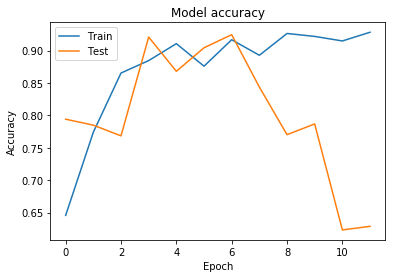

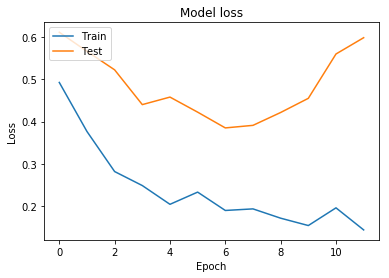

In [8]:
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=106) # Added class weights, reporting prec, recall, and f1


Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 40.86% positive class.
Val set has 514 images with 42.61% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.0003 
Epoch 1/5
65/65 [==============================] - 244s 4s/step - loss: 0.6185 - acc: 0.5048 - sensitivity: 0.5048 - specificity: 0.5048 - f1: 0.6253 - val_loss: 0.7101 - val_acc: 0.4553 - val_sensitivity: 0.4553 - val_specificity: 0.4553 - val_f1: 0.1972

Epoch 00002: val_acc did not improve from 0.45525
Epoch 3/5
65/65 [==============================] - 244s 4s/step - loss: 0.6108 - acc: 0.5289 - sensitivity: 0.5289 - specificity: 0.5289 - f1: 0.6371 - val_loss: 0.7101 - val_acc: 0.4553 - val_sensitivity: 0.4553 - val_specificity: 0.4553 - val_f1: 0.2015

Epoch 0000

65/65 [==============================] - 318s 5s/step - loss: 0.1945 - acc: 0.9116 - sensitivity: 0.9116 - specificity: 0.9116 - f1: 0.9228 - val_loss: 0.4178 - val_acc: 0.8580 - val_sensitivity: 0.8580 - val_specificity: 0.8580 - val_f1: 0.8864

Epoch 00019: val_acc did not improve from 0.90078
Epoch 20/50
65/65 [==============================] - 314s 5s/step - loss: 0.1941 - acc: 0.9096 - sensitivity: 0.9096 - specificity: 0.9096 - f1: 0.9234 - val_loss: 0.4189 - val_acc: 0.8366 - val_sensitivity: 0.8366 - val_specificity: 0.8366 - val_f1: 0.8709

Epoch 00020: val_acc did not improve from 0.90078
Epoch 21/50
65/65 [==============================] - 312s 5s/step - loss: 0.1897 - acc: 0.9192 - sensitivity: 0.9192 - specificity: 0.9192 - f1: 0.9313 - val_loss: 0.4222 - val_acc: 0.8054 - val_sensitivity: 0.8054 - val_specificity: 0.8054 - val_f1: 0.8468

Epoch 00021: val_acc did not improve from 0.90078
Epoch 22/50
65/65 [==============================] - 311s 5s/step - loss: 0.1859 - ac

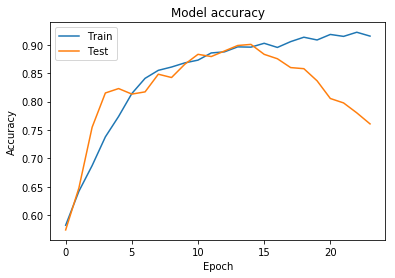

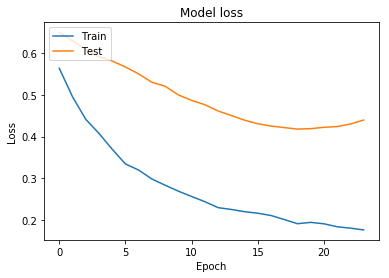

In [18]:
run(model_name='xception', optimizer='sgd', lr=3e-4, train_layers=106) # Added class weights, reporting spec, sens, and f1


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 40.86% positive class.
Val set has 514 images with 42.61% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.0003 
Epoch 1/5
65/65 [==============================] - 257s 4s/step - loss: 0.6906 - acc: 0.5461 - val_loss: 0.6825 - val_acc: 0.5739

Epoch 00001: val_acc improved from -inf to 0.57393, saving model to ../models/xception_L106_drop0.6_sgd-0.0003_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 243s 4s/step - loss: 0.6943 - acc: 0.5356 - val_loss: 0.6825 - val_acc: 

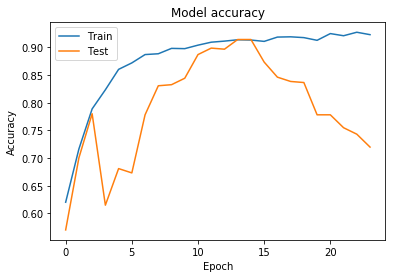

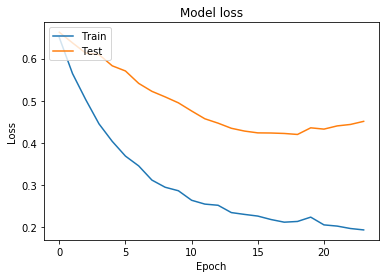

In [7]:
run(model_name='xception', optimizer='sgd', lr=3e-4, train_layers=106)


Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.005 
Epoch 1/5
65/65 [==============================] - 236s 4s/step - loss: 0.7002 - acc: 0.5231 - val_loss: 0.7431 - val_acc: 0.3949

Epoch 00001: val_acc improved from -inf to 0.39494, saving model to ../models/xception_L106_drop0.6_sgd-0.005_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7068 - acc: 0.5264 - val_loss: 0.7431 - val_acc: 0.3949

Epoch 00002: val_acc did not improve from 0.39494
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7001 - acc: 0.5294 - val_loss: 0.7431 - val_acc: 0.3949

Epoch 

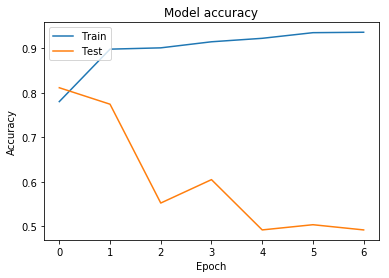

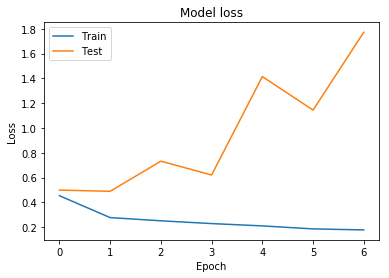

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.008 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.6955 - acc: 0.5404 - val_loss: 0.7079 - val_acc: 0.4533

Epoch 00001: val_acc improved from -inf to 0.45331, saving model to ../models/xception_L106_drop0.6_sgd-0.008_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.6993 - acc: 0.5308 - val_loss: 0.7079 - val_acc: 0.4533

Epoch 00002: val_acc did not improve from 0.45331
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7025 - acc: 0.5366 - val_loss: 0.7079 - val_acc: 0.4533

Epoch 

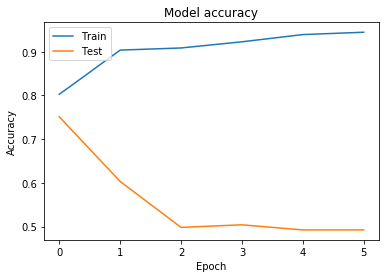

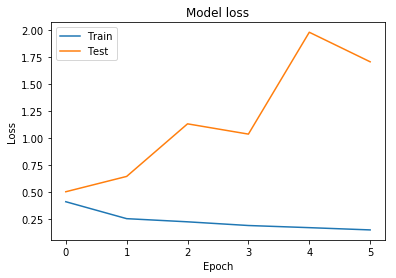

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L96 drop0.6 sgd-0.005 
Epoch 1/5
65/65 [==============================] - 234s 4s/step - loss: 0.6885 - acc: 0.5606 - val_loss: 0.7251 - val_acc: 0.5078

Epoch 00001: val_acc improved from -inf to 0.50778, saving model to ../models/xception_L96_drop0.6_sgd-0.005_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.6927 - acc: 0.5274 - val_loss: 0.7251 - val_acc: 0.5078

Epoch 00002: val_acc did not improve from 0.50778
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.6910 - acc: 0.5476 - val_loss: 0.7251 - val_acc: 0.5078

Epoch 00

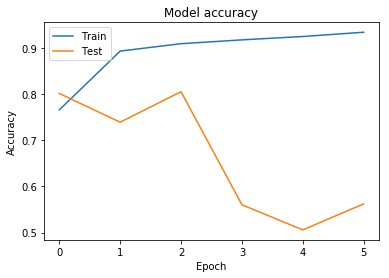

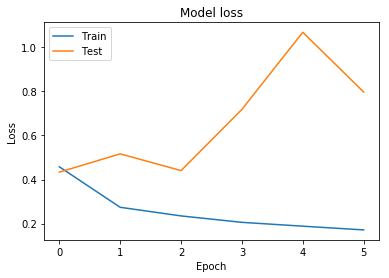

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L96 drop0.6 sgd-0.001 
Epoch 1/5
65/65 [==============================] - 234s 4s/step - loss: 0.7354 - acc: 0.4750 - val_loss: 0.7149 - val_acc: 0.4942

Epoch 00001: val_acc improved from -inf to 0.49416, saving model to ../models/xception_L96_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7275 - acc: 0.4909 - val_loss: 0.7149 - val_acc: 0.4942

Epoch 00002: val_acc did not improve from 0.49416
Epoch 3/5
65/65 [==============================] - 230s 4s/step - loss: 0.7355 - acc: 0.4659 - val_loss: 0.7149 - val_acc: 0.4942

Epoch 00

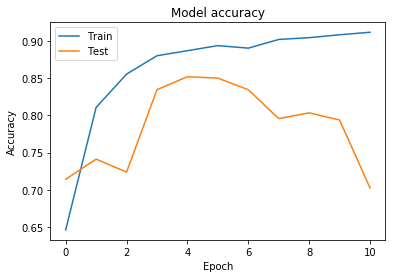

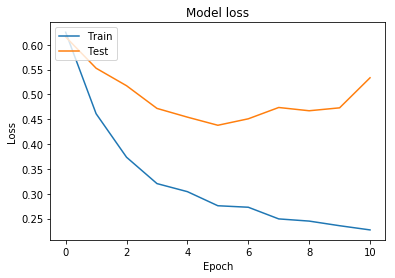

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L96 drop0.6 sgd-0.0005 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.6976 - acc: 0.5351 - val_loss: 0.6611 - val_acc: 0.5739

Epoch 00001: val_acc improved from -inf to 0.57393, saving model to ../models/xception_L96_drop0.6_sgd-0.0005_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.6981 - acc: 0.5346 - val_loss: 0.6611 - val_acc: 0.5739

Epoch 00002: val_acc did not improve from 0.57393
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.6988 - acc: 0.5385 - val_loss: 0.6611 - val_acc: 0.5739

Epoch 

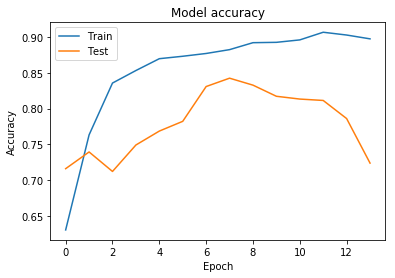

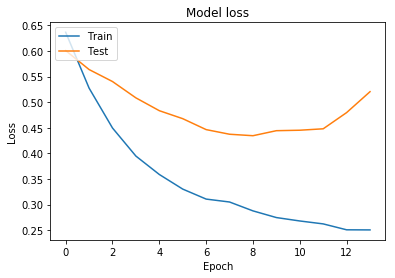

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L96 drop0.6 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 231s 4s/step - loss: 0.7092 - acc: 0.5360 - val_loss: 0.7171 - val_acc: 0.5078

Epoch 00002: val_acc did not improve from 0.50778
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7123 - acc: 0.5216 - val_loss: 0.7171 - val_acc: 0.5078

Epoch 00003: val_acc did not improve from 0.50778
Epoch 4/5
65/65 [==============================] - 231s 4s/step - loss: 0.7097 - acc: 0.5264 - val_loss: 0.7171 - val_acc: 0.5078

Epoch 00004: val_acc did not improve from 0.50778

Starting to fine tune model. Training

Epoch 30/50
65/65 [==============================] - 329s 5s/step - loss: 0.3419 - acc: 0.8650 - val_loss: 0.4712 - val_acc: 0.7938

Epoch 00030: val_acc improved from 0.78016 to 0.79377, saving model to ../models/xception_L96_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 31/50
65/65 [==============================] - 329s 5s/step - loss: 0.3155 - acc: 0.8745 - val_loss: 0.4674 - val_acc: 0.8074

Epoch 00031: val_acc improved from 0.79377 to 0.80739, saving model to ../models/xception_L96_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 32/50
65/65 [==============================] - 329s 5s/step - loss: 0.3188 - acc: 0.8827 - val_loss: 0.4636 - val_acc: 0.8132

Epoch 00032: val_acc improved from 0.80739 to 0.81323, saving model to ../models/xception_L96_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 33/50
65/65 [==============================] - 328s 5s/step - loss: 0.3046 - acc: 0.8899 - val_loss: 0.4604 - val_acc: 0.8152

Epoch 00033: val_acc improved from 0.81323 to 0.81518, saving model to ../m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
run(model_name='xception', optimizer='sgd', lr=5e-3, train_layers=106) # dropout=0.6
run(model_name='xception', optimizer='sgd', lr=8e-3, train_layers=106)
run(model_name='xception', optimizer='sgd', lr=5e-3, train_layers=96)
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=96) # dropout=0.6
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=96)
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=96)

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.001 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.7290 - acc: 0.4943 - val_loss: 0.7378 - val_acc: 0.4903

Epoch 00001: val_acc improved from -inf to 0.49027, saving model to ../models/xception_L106_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7329 - acc: 0.4798 - val_loss: 0.7378 - val_acc: 0.4903

Epoch 00002: val_acc did not improve from 0.49027
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7251 - acc: 0.4952 - val_loss: 0.7378 - val_acc: 0.4903

Epoch 

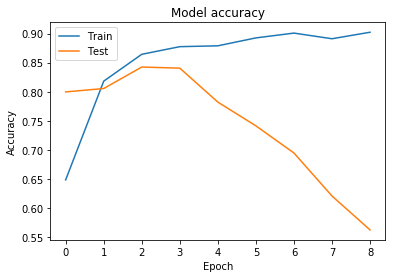

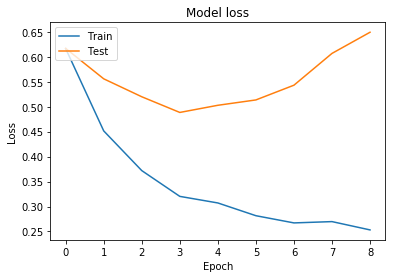

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.0005 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.7260 - acc: 0.4793 - val_loss: 0.6966 - val_acc: 0.4339

Epoch 00001: val_acc improved from -inf to 0.43385, saving model to ../models/xception_L106_drop0.6_sgd-0.0005_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7208 - acc: 0.4802 - val_loss: 0.6966 - val_acc: 0.4339

Epoch 00002: val_acc did not improve from 0.43385
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7231 - acc: 0.4779 - val_loss: 0.6966 - val_acc: 0.4339

Epoc

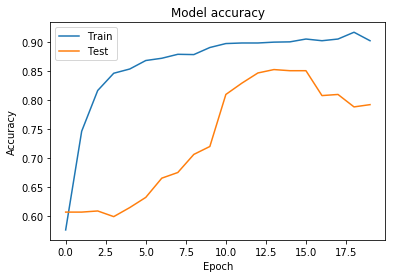

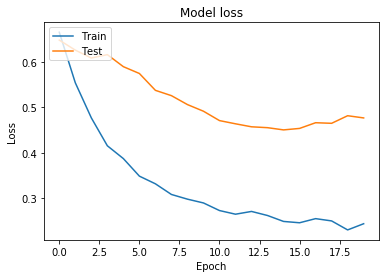

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.6 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 236s 4s/step - loss: 0.7092 - acc: 0.5158 - val_loss: 0.7131 - val_acc: 0.4864

Epoch 00001: val_acc improved from -inf to 0.48638, saving model to ../models/xception_L106_drop0.6_sgd-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7167 - acc: 0.4971 - val_loss: 0.7131 - val_acc: 0.4864

Epoch 00002: val_acc did not improve from 0.48638
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7189 - acc: 0.5067 - val_loss: 0.7131 - val_acc: 0.4864

Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



65/65 [==============================] - 266s 4s/step - loss: 0.2579 - acc: 0.9019 - val_loss: 0.5064 - val_acc: 0.7782

Epoch 00009: val_acc did not improve from 0.80934
Epoch 10/50
65/65 [==============================] - 266s 4s/step - loss: 0.2559 - acc: 0.8976 - val_loss: 0.5425 - val_acc: 0.7237

Epoch 00010: val_acc did not improve from 0.80934
Epoch 11/50
65/65 [==============================] - 266s 4s/step - loss: 0.2494 - acc: 0.9091 - val_loss: 0.6116 - val_acc: 0.6206

Epoch 00011: val_acc did not improve from 0.80934
Model written to ../models/xception_L116_drop0.6_sgd-0.001_/model.json
Saved file to ../models/xception_L116_drop0.6_sgd-0.001_/history.pkl


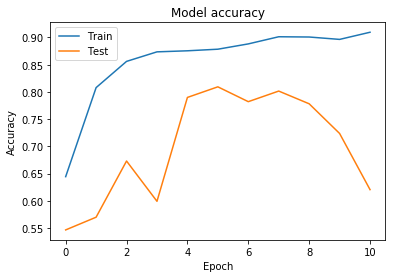

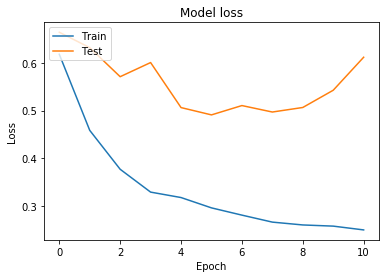

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L116 drop0.6 sgd-0.0005 
Epoch 1/5
65/65 [==============================] - 234s 4s/step - loss: 0.6979 - acc: 0.5318 - val_loss: 0.6846 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to ../models/xception_L116_drop0.6_sgd-0.0005_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.6945 - acc: 0.5361 - val_loss: 0.6846 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.6931 - acc: 0.5457 - val_loss: 0.6846 - val_acc: 0.5000

Epoc

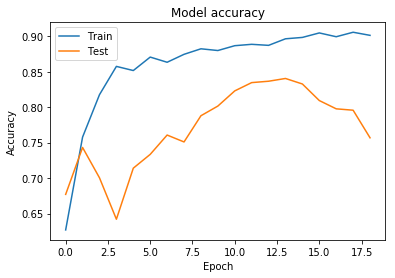

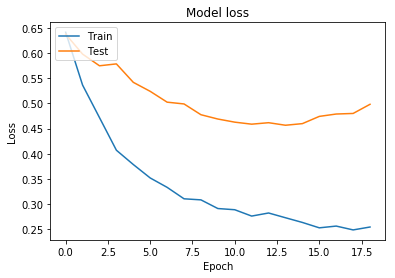

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L116 drop0.6 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.7197 - acc: 0.4861 - val_loss: 0.6988 - val_acc: 0.5019

Epoch 00001: val_acc improved from -inf to 0.50195, saving model to ../models/xception_L116_drop0.6_sgd-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 232s 4s/step - loss: 0.7156 - acc: 0.4957 - val_loss: 0.6988 - val_acc: 0.5019

Epoch 00002: val_acc did not improve from 0.50195
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7232 - acc: 0.4793 - val_loss: 0.6988 - val_acc: 0.5019

Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



65/65 [==============================] - 265s 4s/step - loss: 0.4084 - acc: 0.8471 - val_loss: 0.6005 - val_acc: 0.6245

Epoch 00019: val_acc improved from 0.61673 to 0.62451, saving model to ../models/xception_L116_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 20/50
65/65 [==============================] - 265s 4s/step - loss: 0.4037 - acc: 0.8500 - val_loss: 0.5970 - val_acc: 0.6323

Epoch 00020: val_acc improved from 0.62451 to 0.63230, saving model to ../models/xception_L116_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 21/50
65/65 [==============================] - 265s 4s/step - loss: 0.3983 - acc: 0.8476 - val_loss: 0.5956 - val_acc: 0.6284

Epoch 00021: val_acc did not improve from 0.63230
Epoch 22/50
65/65 [==============================] - 265s 4s/step - loss: 0.3817 - acc: 0.8582 - val_loss: 0.5938 - val_acc: 0.6284

Epoch 00022: val_acc did not improve from 0.63230
Epoch 23/50
65/65 [==============================] - 266s 4s/step - loss: 0.3911 - acc: 0.8553 - val_loss: 0.5892 - 

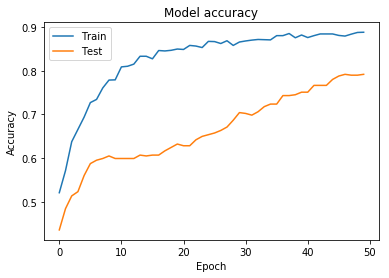

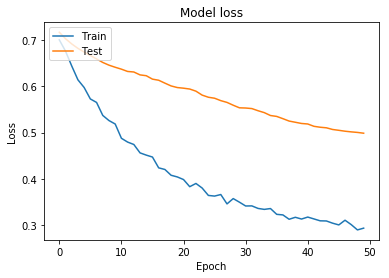

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L126 drop0.6 sgd-0.001 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.7011 - acc: 0.5250 - val_loss: 0.7161 - val_acc: 0.4903

Epoch 00001: val_acc improved from -inf to 0.49027, saving model to ../models/xception_L126_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7034 - acc: 0.5255 - val_loss: 0.7161 - val_acc: 0.4903

Epoch 00002: val_acc did not improve from 0.49027
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7059 - acc: 0.5193 - val_loss: 0.7161 - val_acc: 0.4903

Epoch 

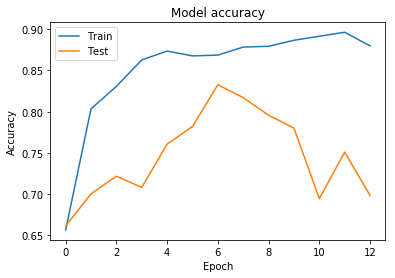

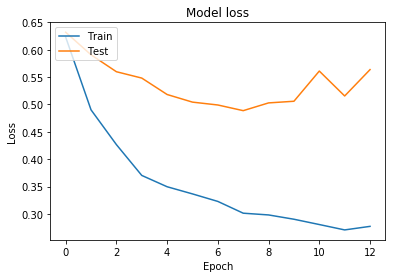

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L126 drop0.6 sgd-0.0005 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.7298 - acc: 0.4658 - val_loss: 0.6991 - val_acc: 0.5058

Epoch 00001: val_acc improved from -inf to 0.50584, saving model to ../models/xception_L126_drop0.6_sgd-0.0005_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7213 - acc: 0.4885 - val_loss: 0.6991 - val_acc: 0.5058

Epoch 00002: val_acc did not improve from 0.50584
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7289 - acc: 0.4764 - val_loss: 0.6991 - val_acc: 0.5058

Epoc

Epoch 31/50
65/65 [==============================] - 244s 4s/step - loss: 0.2595 - acc: 0.9000 - val_loss: 0.4680 - val_acc: 0.8074

Epoch 00031: val_acc did not improve from 0.81712
Epoch 32/50
65/65 [==============================] - 242s 4s/step - loss: 0.2603 - acc: 0.8952 - val_loss: 0.4677 - val_acc: 0.8152

Epoch 00032: val_acc did not improve from 0.81712
Epoch 33/50
65/65 [==============================] - 243s 4s/step - loss: 0.2446 - acc: 0.9034 - val_loss: 0.4666 - val_acc: 0.8113

Epoch 00033: val_acc did not improve from 0.81712
Epoch 34/50
65/65 [==============================] - 243s 4s/step - loss: 0.2565 - acc: 0.8966 - val_loss: 0.4668 - val_acc: 0.8152

Epoch 00034: val_acc did not improve from 0.81712
Epoch 35/50
65/65 [==============================] - 243s 4s/step - loss: 0.2524 - acc: 0.9062 - val_loss: 0.4664 - val_acc: 0.8113

Epoch 00035: val_acc did not improve from 0.81712
Epoch 36/50
65/65 [==============================] - 244s 4s/step - loss: 0.2531 - ac

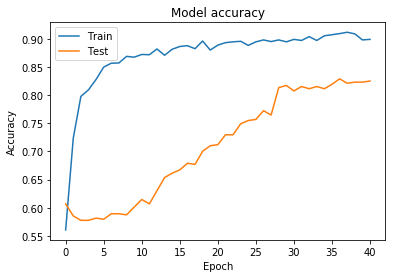

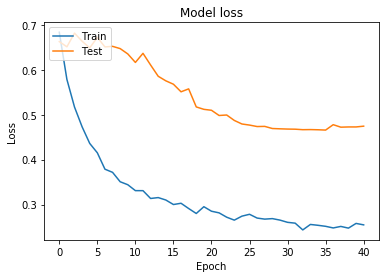

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L126 drop0.6 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 235s 4s/step - loss: 0.7374 - acc: 0.4606 - val_loss: 0.6573 - val_acc: 0.6946

Epoch 00001: val_acc improved from -inf to 0.69455, saving model to ../models/xception_L126_drop0.6_sgd-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7414 - acc: 0.4654 - val_loss: 0.6573 - val_acc: 0.6946

Epoch 00002: val_acc did not improve from 0.69455
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7476 - acc: 0.4558 - val_loss: 0.6573 - val_acc: 0.6946

Epoc

Process ForkPoolWorker-56:
Process ForkPoolWorker-55:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "

KeyboardInterrupt: 

In [18]:
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=106) # dropout=0.6
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=106)
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=106)
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=116)
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=116)
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=116)
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=126)
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=126)
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=126)

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.0008-decay0.0001 
Epoch 1/5
65/65 [==============================] - 233s 4s/step - loss: 0.7182 - acc: 0.4831 - val_loss: 0.7233 - val_acc: 0.3813

Epoch 00001: val_acc improved from -inf to 0.38132, saving model to ../models/xception_L106_drop0.5_sgd-0.0008-decay0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7253 - acc: 0.4788 - val_loss: 0.7233 - val_acc: 0.3813

Epoch 00002: val_acc did not improve from 0.38132
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7245 - acc: 0.4759 - val_loss: 0.7233

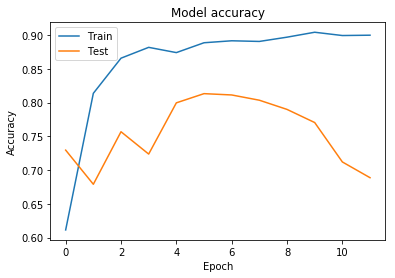

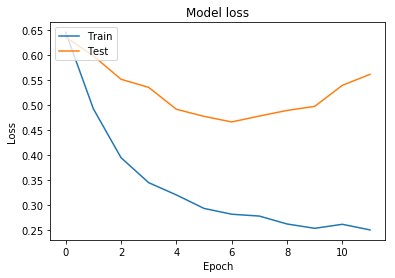

In [16]:
run(model_name='xception', optimizer='sgd', lr=8e-4, train_layers=106) # decay 1e-4
# run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=116)
# run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=116)

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.0005-decay0.0001 
Epoch 1/5
65/65 [==============================] - 238s 4s/step - loss: 0.7059 - acc: 0.5408 - val_loss: 0.7238 - val_acc: 0.5097

Epoch 00001: val_acc improved from -inf to 0.50973, saving model to ../models/xception_L106_drop0.5_sgd-0.0005-decay0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7042 - acc: 0.5178 - val_loss: 0.7238 - val_acc: 0.5097

Epoch 00002: val_acc did not improve from 0.50973
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7073 - acc: 0.5322 - val_loss: 0.7238

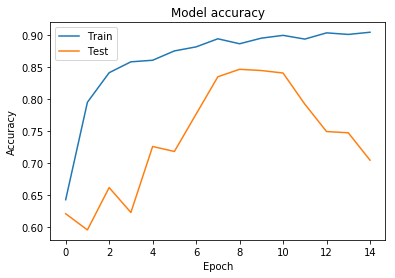

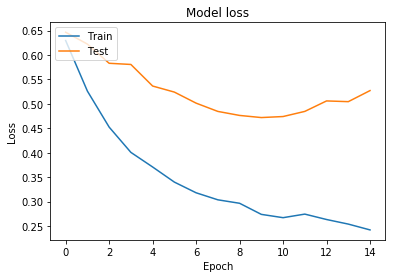

In [14]:
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=106) # decay 1e-4
# run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=116)
# run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=116)

In [12]:
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=106) # decay 0.05
# run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=116)
# run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=116)

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.001-decay0.05 
Epoch 1/5
65/65 [==============================] - 231s 4s/step - loss: 0.7335 - acc: 0.5048 - val_loss: 0.7319 - val_acc: 0.5078

Epoch 00002: val_acc did not improve from 0.50778
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7360 - acc: 0.4952 - val_loss: 0.7319 - val_acc: 0.5078

Epoch 00003: val_acc did not improve from 0.50778
Epoch 4/5
65/65 [==============================] - 231s 4s/step - loss: 0.7373 - acc: 0.5053 - val_loss: 0.7319 - val_acc: 0.5078
Epoch 1/5

Epoch 00004: val_acc did not improve from 0.50778

Starting to fine 

Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorf

Epoch 1/50


  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


Epoch 1/50


KeyboardInterrupt: 

In [11]:
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=106) # decay 0.05
# run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=116)
# run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=116)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.0005-decay0.05 
Epoch 1/5
65/65 [==============================] - 243s 4s/step - loss: 0.7372 - acc: 0.4558 - val_loss: 0.7100 - val_acc: 0.5078

Epoch 00001: val_acc improved from -inf to 0.50778, saving model to ../models/xception_L106_drop0.5_sgd-0.0005-decay0.05_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7320 - acc: 0.4480 - val_loss: 0.71

Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/an

KeyboardInterrupt: 

In [ ]:
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=106)
# run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=116)
# run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=116)

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 234s 4s/step - loss: 0.7049 - acc: 0.5063 - val_loss: 0.7555 - val_acc: 0.4455

Epoch 00001: val_acc improved from -inf to 0.44553, saving model to ../models/xception_L106_drop0.5_sgd-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 230s 4s/step - loss: 0.7061 - acc: 0.5053 - val_loss: 0.7555 - val_acc: 0.4455

Epoch 00002: val_acc did not improve from 0.44553
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7090 - acc: 0.4990 - val_loss: 0.7555 - val_acc: 0.4455

Epoc

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.0005 
Epoch 1/5
65/65 [==============================] - 231s 4s/step - loss: 0.7128 - acc: 0.5019 - val_loss: 0.6931 - val_acc: 0.4922

Epoch 00002: val_acc did not improve from 0.49222
Epoch 3/5
65/65 [==============================] - 231s 4s/step - loss: 0.7181 - acc: 0.4986 - val_loss: 0.6931 - val_acc: 0.4922

Epoch 00003: val_acc did not improve from 0.49222
Epoch 4/5
65/65 [==============================] - 231s 4s/step - loss: 0.7093 - acc: 0.5173 - val_loss: 0.6931 - val_acc: 0.4922

Epoch 00004: val_acc did not improve from 0.49222

Starting to fine tune model. Trainin

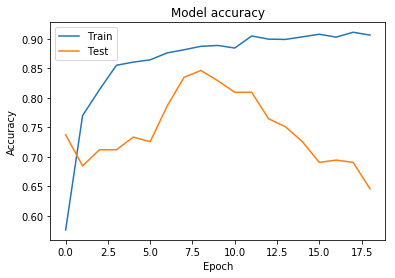

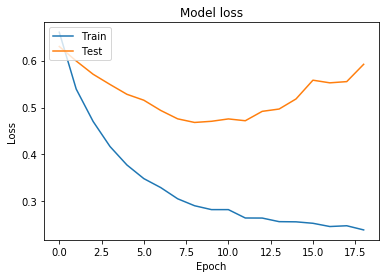

In [13]:
run(model_name='xception', optimizer='sgd', lr=5e-4, train_layers=106)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L106 drop0.5 sgd-0.001 
Epoch 1/5
65/65 [==============================] - 244s 4s/step - loss: 0.7204 - acc: 0.5019 - val_loss: 0.7099 - val_acc: 0.5409

Epoch 00001: val_acc improved from -inf to 0.54086, saving model to ../models/xception_L106_drop0.5_sgd-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 231s 4s/step - loss: 0.7144 - acc: 0.5173 - val_loss: 0.7099 - val_acc: 0.5409



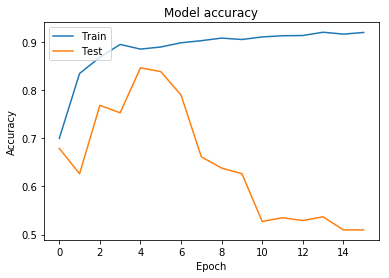

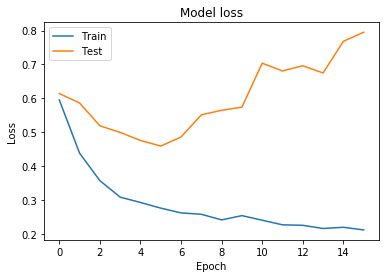

In [10]:
run() # 106 layers, sgd=1e-3, dropout=0.5

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L116 drop0.5 sgd-0.001 
Epoch 1/10
65/65 [==============================] - 263s 4s/step - loss: 0.7376 - acc: 0.5106 - val_loss: 0.7234 - val_acc: 0.4086

Epoch 00001: val_acc improved from -inf to 0.40856, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 254s 4s/step - loss: 0.7457 - acc: 0.5139 - val_loss: 0.7234 - val_acc: 0.4086

Epoch 00002: val_acc did not improve from 0.40856
Epoch 3/10
65/65 [==============================] - 254s 4s/step - loss: 0.7302 - acc: 0.5111 - val_loss: 0.7234 - val_acc: 0.4086

Epoch 00003: val_acc did no

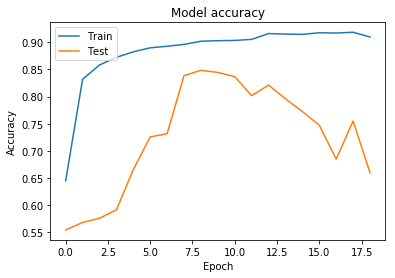

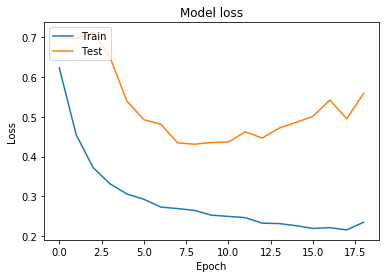

In [29]:
run() # sgd=1e-3, dropout=0.5

In [27]:
run() # adadelta, dropout = 0.4


Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L116 drop0.4 adadelta
Epoch 1/10
65/65 [==============================] - 262s 4s/step - loss: 0.7385 - acc: 0.4774 - val_loss: 0.7043 - val_acc: 0.4261

Epoch 00001: val_acc improved from -inf to 0.42607, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 254s 4s/step - loss: 0.7371 - acc: 0.4779 - val_loss: 0.7043 - val_acc: 0.4261

Epoch 00002: val_acc did not improve from 0.42607
Epoch 3/10
65/65 [==============================] - 255s 4s/step - loss: 0.7355 - acc: 0.4813 - val_loss: 0.7043 - val_acc: 0.4261

Epoch 00003: val_acc did not 

Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File 

KeyboardInterrupt: 

In [25]:
run() # nadam, dropout=0.4

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L116 drop0.4 nadam
Epoch 1/10
65/65 [==============================] - 260s 4s/step - loss: 0.7180 - acc: 0.4735 - val_loss: 0.7194 - val_acc: 0.4280

Epoch 00001: val_acc improved from -inf to 0.42802, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 254s 4s/step - loss: 0.7228 - acc: 0.4712 - val_loss: 0.7194 - val_acc: 0.4280

Epoch 00002: val_acc did not improve from 0.42802
Epoch 3/10
65/65 [==============================] - 254s 4s/step - loss: 0.7143 - acc: 0.4808 - val_loss: 0.7194 - val_acc: 0.4280

Epoch 00003: val_acc did not imp

Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensor

Epoch 1/50


  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


Epoch 1/50


KeyboardInterrupt: 

In [23]:
run() # nadam, dropout=0.4 -> 1024 dense -> dropout=0.4

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Running model with params: L116 drop0.4 dense1024relu drop0.4 nadam
Epoch 1/10
65/65 [==============================] - 259s 4s/step - loss: 0.6995 - acc: 0.5351 - val_loss: 0.6878 - val_acc: 0.4922

Epoch 00001: val_acc improved from -inf to 0.49222, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 255s 4s/step - loss: 0.6965 - acc: 0.5438 - val_loss: 0.6878 - val_acc: 0.4922

Epoch 00002: val_acc did not improve from 0.49222
Epoch 3/10
65/65 [==============================] - 255s 4s/step - loss: 0.6987 - acc: 0.5355 - val_loss: 0.6878 - val_acc: 0.4922

Epoch 0000

Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/ana

KeyboardInterrupt: 

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Epoch 1/10
65/65 [==============================] - 266s 4s/step - loss: 0.7182 - acc: 0.4845 - val_loss: 0.6914 - val_acc: 0.5973

Epoch 00001: val_acc improved from -inf to 0.59728, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 256s 4s/step - loss: 0.7094 - acc: 0.4995 - val_loss: 0.6914 - val_acc: 0.5973

Epoch 00002: val_acc did not improve from 0.59728
Epoch 3/10
65/65 [==============================] - 256s 4s/step - loss: 0.7162 - acc: 0.4832 - val_loss: 0.6914 - val_acc: 0.5973

Epoch 00003: val_acc did not improve from 0.59728
Epoch 4/10
65/65 [==========

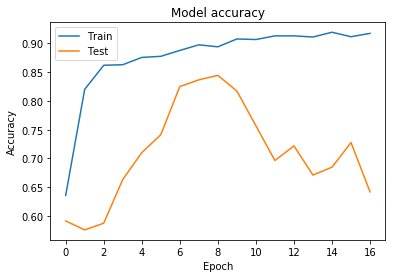

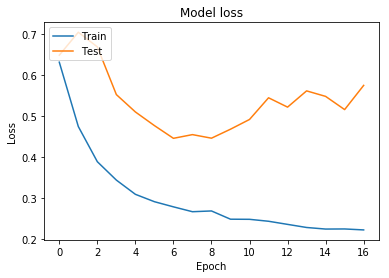

In [20]:
run() # sgd: 1e-3; dropout=0.4 -> 1024 dense -> dropout=0.4

In [10]:
run() # sgd: 1e-4; 1024 dense layer; dropout: 0.4

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Epoch 1/10
65/65 [==============================] - 269s 4s/step - loss: 0.7176 - acc: 0.4457 - val_loss: 0.7002 - val_acc: 0.5564

Epoch 00001: val_acc improved from -inf to 0.55642, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 255s 4s/step - loss: 0.7194 - acc: 0.4419 - val_loss: 0.7002 - val_acc: 0.5564

Epoch 00002: val_acc did not improve from 0.55642
Epoch 3/10
65/65 [=====

Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-3:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaco

KeyboardInterrupt: 

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Epoch 1/10
65/65 [==============================] - 256s 4s/step - loss: 0.6942 - acc: 0.5313 - val_loss: 0.7425 - val_acc: 0.5078

Epoch 00002: val_acc did not improve from 0.50778
Epoch 3/10
65/65 [==============================] - 256s 4s/step - loss: 0.6918 - acc: 0.5428 - val_loss: 0.7425 - val_acc: 0.5078

Epoch 00003: val_acc did not improve from 0.50778
Epoch 4/10
65/65 [==============================] - 257s 4s/step - loss: 0.6925 - acc: 0.5304 - val_loss: 0.7425 - val_acc: 0.5078

Epoch 00004: val_acc did not improve from 0.50778
Epoch 5/10
65/65 [==============================] - 256s 4s/step - loss: 0.6879 - acc:

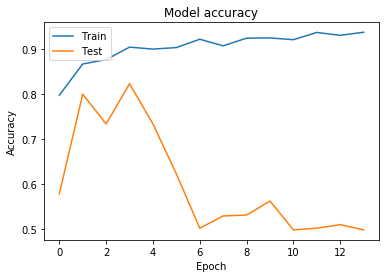

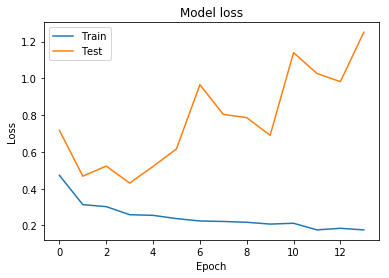

In [26]:
run() # sgd: 5e-3, dropout: 0.4

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Epoch 1/10
65/65 [==============================] - 260s 4s/step - loss: 0.7104 - acc: 0.4861 - val_loss: 0.6664 - val_acc: 0.6265

Epoch 00001: val_acc improved from -inf to 0.62646, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 257s 4s/step - loss: 0.7139 - acc: 0.4914 - val_loss: 0.6664 - val_acc: 0.6265

Epoch 00002: val_acc did not improve from 0.62646
Epoch 3/10
65/65 [==============================] - 257s 4s/step - loss: 0.7149 - acc: 0.4639 - val_loss: 0.6664 - val_acc: 0.6265

Epoch 00003: val_acc did not improve from 0.62646
Epoch 4/10
65/65 [==========

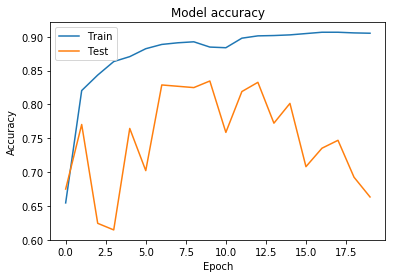

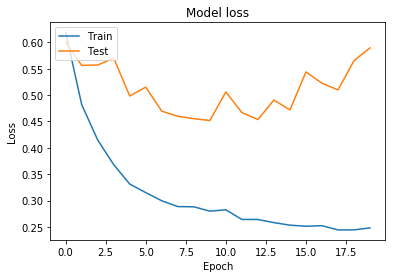

In [22]:
run() # sgd: 1e-3, dropout: 0.4

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Epoch 1/10
65/65 [==============================] - 261s 4s/step - loss: 0.7455 - acc: 0.4356 - val_loss: 0.7483 - val_acc: 0.3054

Epoch 00001: val_acc improved from -inf to 0.30545, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 255s 4s/step - loss: 0.7435 - acc: 0.4457 - val_loss: 0.7483 - val_acc: 0.3054

Epoch 00002: val_acc did not improve from 0.30545
Epoch 3/10
65/65 [==============================] - 256s 4s/step - loss: 0.7393 - acc: 0.4553 - val_loss: 0.7483 - val_acc: 0.3054

Epoch 00003: val_acc did not improve from 0.30545
Epoch 4/10
65/65 [==========

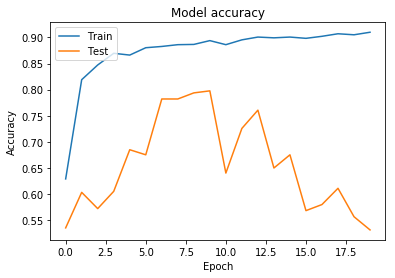

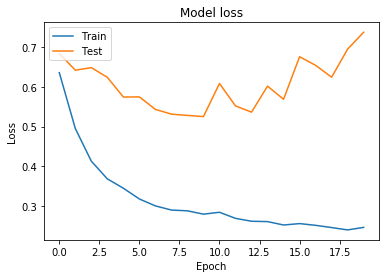

In [20]:
run() # sgd with 1e-3; dropout at 0.3 to dense

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Epoch 1/10
65/65 [==============================] - 260s 4s/step - loss: 0.7043 - acc: 0.4851 - val_loss: 0.6944 - val_acc: 0.5156

Epoch 00001: val_acc improved from -inf to 0.51556, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 257s 4s/step - loss: 0.7037 - acc: 0.4870 - val_loss: 0.6944 - val_acc: 0.5156

Epoch 00002: val_acc did not improve from 0.51556
Epoch 3/10
65/65 [==============================] - 257s 4s/step - loss: 0.7012 - acc: 0.5077 - val_loss: 0.6944 - val_acc: 0.5156

Epoch 00004: val_acc did not improve from 0.51556
Epoch 5/10
65/65 [==========

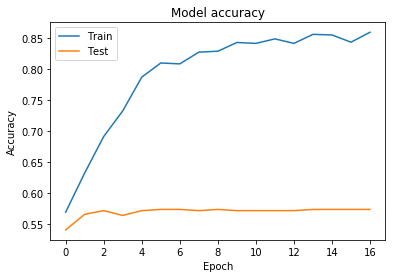

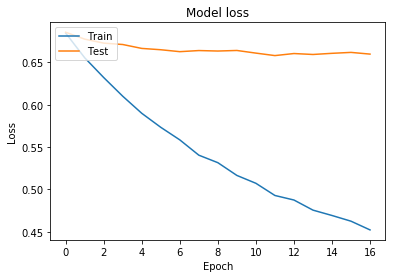

In [15]:
run() # data set is finally balanced; sgd with 1e-4; single dropout to dense

In [ ]:
run() # running with sgd at 1e-4, dropout

Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Epoch 1/10
65/65 [==============================] - 262s 4s/step - loss: 0.6667 - acc: 0.6038 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00001: val_acc improved from -inf to 0.59339, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 254s 4s/step - loss: 0.6603 - acc: 0.6168 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00002: val_acc did not improve from 0.59339
Epoch 3/10
65/65 [==============================] - 255s 4s/step - loss: 0.6633 - acc: 0.6097 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00004: val_acc did not improve from 0.59339
Epoch 5/10
65/65 [==============================] - 254s 4s/step - loss: 0.6643 - acc: 0.6043 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00005: val_acc did not improve from 0.59339
Epoch 6/10
65/65 [==============================] - 257s 4s/step - loss: 0.6610 - acc: 0.6076 - val_loss: 0.6769 - val_acc: 0.5934

Epoch 00006: val_acc did not improve from 0.59339

Starting to fine tune model. Tr

In [35]:
run() # running with sgd at 1e-4, dense 1024, dropout 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_

Epoch 1/10
65/65 [==============================] - 258s 4s/step - loss: 0.6621 - acc: 0.6034 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00001: val_acc improved from -inf to 0.59728, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 257s 4s/step - loss: 0.6651 - acc: 0.5942 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00002: val_acc did not improve from 0.59728
Epoch 3/10
65/65 [==============================] - 257s 4s/step - loss: 0.6654 - acc: 0.6019 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00003: val_acc did not improve from 0.59728
Epoch 4/10
65/65 [==============================] - 257s 4s/step - loss: 0.6646 - acc: 0.5894 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00004: val_acc did not improve from 0.59728
Epoch 5/10
65/65 [==============================] - 256s 4s/step - loss: 0.6632 - acc: 0.6105 - val_loss: 0.6643 - val_acc: 0.5973

Epoch 00005: val_acc did not improve from 0.59728
Epoch 6/10
65/65 [==============


Epoch 00033: val_acc improved from 0.72568 to 0.72957, saving model to ../models/xception/model_weights.h5
Epoch 34/50
65/65 [==============================] - 271s 4s/step - loss: 0.4397 - acc: 0.8009 - val_loss: 0.5921 - val_acc: 0.7315

Epoch 00034: val_acc improved from 0.72957 to 0.73152, saving model to ../models/xception/model_weights.h5
Epoch 35/50
65/65 [==============================] - 271s 4s/step - loss: 0.4364 - acc: 0.8014 - val_loss: 0.5899 - val_acc: 0.7276

Epoch 00035: val_acc did not improve from 0.73152
Epoch 36/50
65/65 [==============================] - 271s 4s/step - loss: 0.4398 - acc: 0.7976 - val_loss: 0.5886 - val_acc: 0.7296

Epoch 00036: val_acc did not improve from 0.73152
Epoch 37/50
65/65 [==============================] - 271s 4s/step - loss: 0.4362 - acc: 0.7961 - val_loss: 0.5871 - val_acc: 0.7237

Epoch 00037: val_acc did not improve from 0.73152
Epoch 38/50
65/65 [==============================] - 270s 4s/step - loss: 0.4320 - acc: 0.7956 - val_lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
run()

Instructions for updating:
Colocations handled automatically by placer.
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 118, 909, 32) 0           block1_conv1_bn[0][0]            
______________________

65/65 [==============================] - 269s 4s/step - loss: 0.6445 - acc: 0.6380 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00001: val_acc improved from -inf to 0.46887, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
65/65 [==============================] - 256s 4s/step - loss: 0.6453 - acc: 0.6375 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00002: val_acc did not improve from 0.46887
Epoch 3/10
65/65 [==============================] - 255s 4s/step - loss: 0.6442 - acc: 0.6370 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00003: val_acc did not improve from 0.46887
Epoch 4/10
65/65 [==============================] - 256s 4s/step - loss: 0.6444 - acc: 0.6384 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00004: val_acc did not improve from 0.46887
Epoch 5/10
65/65 [==============================] - 254s 4s/step - loss: 0.6460 - acc: 0.6332 - val_loss: 0.7294 - val_acc: 0.4689

Epoch 00005: val_acc did not improve from 0.46887
Epoch 6/10
65/65 [=========================

Seeing no positive results.

Ideas for addressing:
* more data
* one hot encode and do a categorical rather than binary classification
* try different optimizers--adam, or sgd with clipvalue=0.5
* try a sigmoid activation function
* check the probabilities
* dropout layer
* unlock deeper convolutional layers. Maybe an entire additional block?
* could also try training from scratch or looking for other good pre-trained sets

Topic expansion:
* image classification/tagging by weather status: sunny, clear, partly cloudy, cloudy, rainy, snowy, sunset, sunrise, night, pretty, beautiful, stunning

# Interpreting Results

In [5]:
from keras.models import model_from_json

def load_model(name):
    model_path = f'../models/{name}/'

    # Model reconstruction from JSON file
    with open(model_path + 'model.json', 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(model_path + 'model_weights.h5')
    return model

Using TensorFlow backend.


In [6]:
model = load_model('xception')

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
img_height, img_width = (237, 1820)
batch_size = 32

train, val, test = get_data()

train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)

# callbacks_list = [
#     ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=0)
# ]

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 1878 images with 22.74% positive class.
Val set has 470 images with 22.77% positive class.
Test set has 588 images with 21.43% positive class.

Found 1878 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


In [31]:
train_generator.reset()
predictions = model.predict_generator(train_generator, 
                                      steps=np.ceil(len(train) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

48/48 [==============================] - 151s 3s/step


1.0    1530
Name: 0, dtype: int64

In [23]:
predictions = model.predict_generator(val_generator, 
                                      steps=np.ceil(len(val) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

12/12 [==============================] - 37s 3s/step


1.0    383
Name: 0, dtype: int64

In [52]:
train_generator.class_indices

{'beautiful': 0, 'fine': 1}

In [40]:
val_generator.class_indices

{'beautiful': 0, 'fine': 1}